In [1]:
import numpy as np
import xarray as xr
import viz
import mplRC
import extremespaper as ex
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as mcol
import cartopy.crs as ccrs
import cmocean
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.optimize as scopt
from functools import partial
mplRC.paperRC2();

/home/ords/crd/ccrn/reo000/mamba_files/envs/mpy39dc/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
exdir=ex.exdirs
varlist=['tos','hplusos','omega_arag_0','spco2',]#'o2_mean_100_600']#,'intpp']
freq='daily'
scenList=['ESM4_historical_D1','ESM4_ssp126_D1','ESM4_ssp370_D1']

In [3]:
stats=ex.load_stats(scenList,varlist,freq=freq)

In [4]:
stats['ESM4_historical_D1']['omega_arag_0']['qt_dt'].sel(quantile=0.05).std().values


array(0.97521622)

In [5]:
stats['ESM4_historical_D1']['omega_arag_0']

<xarray.Dataset> Size: 12GB
Dimensions:      (time: 1, lat: 180, lon: 360, quantile: 13, b: 2, YD: 365,
                  YD5: 73)
Coordinates:
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    z_l          float64 8B ...
  * lon          (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time         (time) object 8B 1995-01-01 00:00:00
  * YD           (YD) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * quantile     (quantile) float64 104B 0.0 0.02 0.05 0.07 ... 0.95 0.98 1.0
  * b            (b) int64 16B 0 1
  * YD5          (YD5) int64 584B 1 6 11 16 21 26 31 ... 336 341 346 351 356 361
Data variables: (12/22)
    mean         (time, lat, lon) float32 259kB ...
    var          (time, lat, lon) float32 259kB ...
    qt           (quantile, lat, lon) float64 7MB ...
    linfitcoef   (b, lat, lon) float64 1MB ...
    binseas      (YD, lat, lon) float64 189MB ...
    seas         (YD, lat, lon) float64 189MB ...
    ...           ...
    ydqt_ds2     (YD5, quantile, lat, lon) float64 492MB ...
    ydqt_dtds2   (YD5, quantile, lat, lon) float64 492MB ...
    ydqt2S       (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dt2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_ds2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dtds2S  (YD, quantile, lat, lon) float64 2GB ...
Attributes:
    long_name:                   Aragonite Saturation State
    units:                       
    year-day quantile Descript:  full series fits are applied to dt and ds va...
    ydqt halfwindow:             2

In [6]:
qqh=0.95
qql=0.05

In [7]:
ff=stats['ESM4_historical_D1']['omega_arag_0']
wgt=xr.DataArray(data=viz.areacello1x1,
            coords={'lat': ff.lat,'lon': ff.lon}, 
            dims=["lat", "lon"])#.stack(xy=['lat','lon'])
wgt

<xarray.DataArray (lat: 180, lon: 360)> Size: 259kB
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [5.4072147e+08, 5.4074317e+08, 5.4076685e+08, ..., 5.4064634e+08,
        5.4067046e+08, 5.4069542e+08],
       [3.2441066e+08, 3.2445338e+08, 3.2449613e+08, ..., 3.2429258e+08,
        3.2433165e+08, 3.2437091e+08],
       [1.0705158e+08, 1.0716678e+08, 1.0728018e+08, ..., 1.0671161e+08,
        1.0681889e+08, 1.0693562e+08]], dtype=float32)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5

In [8]:
meanDelt={}
stdvDelt={}
for iscen in ['ESM4_ssp126_D1','ESM4_ssp370_D1']:
    for ivar in ['omega_arag_0','tos','spco2','hplusos']:
        A=1/101325*1e6 if ivar=='spco2' else 1
        for qq in [qql,qqh]:
            delta=(stats[iscen][ivar]['qt_dt'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))*A
            meanDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).mean().values)
            stdvDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).std().values)
        deltaM=(stats[iscen][ivar]['mean_dt'][0,:,:]-stats['ESM4_historical_D1'][ivar]['mean_dt'][0,:,:])*A
        meanDelt[(iscen,ivar,'mean')]=(float(deltaM.weighted(wgt.fillna(0)).mean().values))
        stdvDelt[(iscen,ivar,'mean')]=(float(deltaM.weighted(wgt.fillna(0)).std().values))

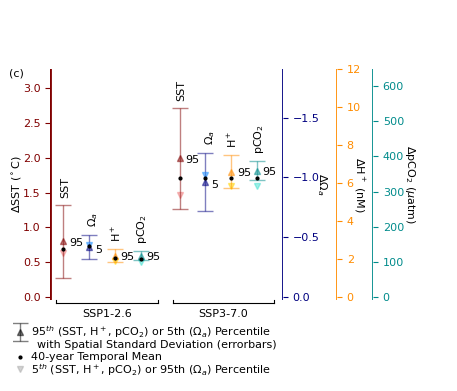

In [9]:
##### ORIGINAL VERSION SHOWING ABSOLUTE CHANGE IN OMEGA_A EVEN THOUGH OMEGA_A IS A RATIO
s=2.4
ms1=4
fs1=8
cs=6
fig,ax1=plt.subplots(1,1,figsize=(3,3))
p1=ax1.get_position().bounds

isc='ESM4_ssp126_D1'
ivar='tos'
ax1.plot(0,meanDelt[(isc,ivar,qql)],marker='v',color='lightcoral',alpha=.5,ms=ms1)
ax1.errorbar(0,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='maroon',alpha=.5,ms=ms1)
ax1.annotate(str(int(qqh*100)),xy=[0,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)#+'$^{th}$'
ax1.annotate('SST',xy=[0,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90,annotation_clip=False)
ax1.plot(0,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='omega_arag_0'
ax2=ax1.twinx()
ax2.errorbar(0.1,meanDelt[(isc,ivar,qql)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='navy',alpha=.5,ms=ms1)
ax2.plot(0.1,meanDelt[(isc,ivar,qqh)],marker='v',color='dodgerblue',alpha=.5,ms=ms1)
ax2.annotate(str(int(qql*100)),xy=[0.1,meanDelt[(isc,ivar,qql)]],xytext=[4,-2],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax2.annotate('$\Omega _{a}$',xy=[0.1,meanDelt[(isc,ivar,qqh)]-stdvDelt[(isc,ivar,qqh)]],xytext=[3,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax2.plot(0.1,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='hplusos'
ax3=ax1.twinx()
ax3.plot(0.2,1e3*meanDelt[(isc,ivar,qql)],marker='v',color='gold',alpha=.5,ms=ms1)
ax3.errorbar(0.2,1e3*meanDelt[(isc,ivar,qqh)],yerr=1e3*stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkorange',alpha=.5,ms=ms1)
ax3.annotate(str(int(qqh*100)),xy=[0.2,1e3*meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax3.annotate('H$^+$',xy=[0.2,1e3*meanDelt[(isc,ivar,qqh)]+1e3*stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax3.plot(0.2,1e3*meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='spco2'
ax4=ax1.twinx()
ax4.plot(0.3,meanDelt[(isc,ivar,qql)],marker='v',color='turquoise',alpha=.5,ms=ms1)
ax4.errorbar(0.3,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='darkcyan',alpha=.5,ms=ms1)
ax4.annotate(str(int(qqh*100)),xy=[0.3,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax4.annotate('pCO$_2$',xy=[0.3,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax4.plot(0.3,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

isc='ESM4_ssp370_D1'
ivar='tos'
ax1.plot(.45,meanDelt[(isc,ivar,qql)],marker='v',color='lightcoral',alpha=.5,ms=ms1)
ax1.errorbar(.45,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='maroon',alpha=.5,ms=ms1)
ax1.annotate(str(int(qqh*100)),xy=[.45,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax1.annotate('SST',xy=[0.45,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90,annotation_clip=False)
ax1.plot(.45,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax1.set_ylim(-.01*s*a,.8*s*a)

ivar='omega_arag_0'
ax2.errorbar(0.55,meanDelt[(isc,ivar,qql)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='navy',alpha=.5,ms=ms1)
ax2.plot(0.55,meanDelt[(isc,ivar,qqh)],marker='v',color='dodgerblue',alpha=.5,ms=ms1)
ax2.annotate(str(int(qql*100)),xy=[0.55,meanDelt[(isc,ivar,qql)]],xytext=[4,-2],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax2.annotate('$\Omega _{a}$',xy=[0.55,meanDelt[(isc,ivar,qqh)]-stdvDelt[(isc,ivar,qqh)]],xytext=[3,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax2.plot(0.55,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax2.set_ylim(-.01*s*a,.8*s*a)

ivar='hplusos'
ax3.plot(0.65,1e3*meanDelt[(isc,ivar,qql)],marker='v',color='gold',alpha=.5,ms=ms1)
ax3.errorbar(0.65,1e3*meanDelt[(isc,ivar,qqh)],yerr=1e3*stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkorange',alpha=.5,ms=ms1)
ax3.annotate(str(int(qqh*100)),xy=[0.65,1e3*meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax3.annotate('H$^+$',xy=[0.65,1e3*meanDelt[(isc,ivar,qqh)]+1e3*stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax3.plot(0.65,1e3*meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=1e3*meanDelt[(isc,ivar,'mean')]
ax3.set_ylim(-.01*s*a,.8*s*a)

ivar='spco2'
ax4.plot(0.75,meanDelt[(isc,ivar,qql)],marker='v',color='turquoise',alpha=.5,ms=ms1)
ax4.errorbar(0.75,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkcyan',alpha=.5,ms=ms1)
ax4.annotate(str(int(qqh*100)),xy=[0.75,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax4.annotate('pCO$_2$',xy=[0.75,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,5],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax4.plot(0.75,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax4.set_ylim(-.01*s*a,.8*s*a)

ax1.set_xlim(-.05,.85)
for iax in [ax1,ax2,ax3,ax4]:
    iax.set_frame_on(False)
    iax.yaxis.set_visible(False)
    
    
def showax(axx,shift,color,side):
    p0=axx.get_position().bounds
    if side=='left':
        p1=[p0[0]+shift,p0[1],.02,p0[3]]
        axb=fig.add_axes(p1,sharey=axx,frameon=False)
        axb.spines['left'].set_color(color)
        axb.get_yaxis().set_visible(True)
        xmin, xmax = axb.get_xaxis().get_view_interval()
        ymin, ymax = axb.get_yaxis().get_view_interval()
        axb.add_artist(Line2D((xmin, xmin), (ymin, ymax), color=color, linewidth=2))
    else:
        p1=[p0[0]+p0[2]-.02+shift,p0[1],.02,p0[3]]
        axb=fig.add_axes(p1,sharey=axx,frameon=False)
        axb.spines['right'].set_color(color)
        axb.spines['left'].set_visible(False)
        xmin, xmax = axb.get_xaxis().get_view_interval()
        ymin, ymax = axb.get_yaxis().get_view_interval()
        axb.add_artist(Line2D((xmax, xmax), (ymin, ymax), color=color, linewidth=2))
        axb.yaxis.tick_right()
        axb.yaxis.set_label_position("right")
    axb.tick_params(axis='y', colors=color)
    #axb.spines['top'].set_visible(False)
    #axb.spines['bottom'].set_visible(False)
    axb.set_xticks([])
    return axb
        
ax1b=showax(ax1,0,'maroon','left')
ax2b=showax(ax2,0,'navy','right')
ax3b=showax(ax3,.18,'darkorange','right')
ax4b=showax(ax4,.3,'darkcyan','right')
ax1b.set_ylabel('$\Delta$SST ($^\circ$C)',labelpad=0)
ax2b.set_ylabel('$\Delta \Omega _{a}$',rotation=-90,labelpad=6.5)
ax3b.set_ylabel('$\Delta$H$^+$ (nM)',rotation=-90,labelpad=4)
ax4b.set_ylabel('$\Delta$pCO$_2$ ($\mu$atm)',rotation=-90,labelpad=9)
ax1.set_xticks([]);
ax2b.set_yticks([0,-.5,-1,-1.5])

axl1=fig.add_axes([p1[0]+.02,p1[1]-.01,p1[2]/2-.05,.01])
axl2=fig.add_axes([p1[0]+.02+p1[2]/2,p1[1]-.01,p1[2]/2-.05,.01])
for iax in [axl1,axl2]:
    iax.set_xticks([])
    iax.set_yticks([])
    iax.spines[['top']].set_visible(False)
axl1.set_xlabel('SSP1-2.6')
axl2.set_xlabel('SSP3-7.0')

axl=fig.add_axes([0*p1[0],p1[1]-.27,p1[2]*1.87,.2])
axl.errorbar(1,.82,yerr=.15,
           capsize=cs,linestyle='None',marker='^',color='k',alpha=.5,ms=ms1)
axl.plot(1,.4,'.',color='k',ms=ms1)
axl.plot(1,.2,'v',color='darkgray',alpha=.5,ms=ms1)
axl.annotate('95$^{th}$ (SST, H$^+$, pCO$_2$) or 5th ($\Omega _{a}$) Percentile',
             xy=[1.08,.83],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.annotate('with Spatial Standard Deviation (errorbars)',
             xy=[1.2,.63],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.annotate('40-year Temporal Mean',
             xy=[1.08,.4],xytext=[5,0],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.annotate('5$^{th}$ (SST, H$^+$, pCO$_2$) or 95th ($\Omega _{a}$) Percentile',
             xy=[1.08,.2],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.set_axis_off()
axl.set_xlim(0.85,10)
axl.set_ylim(0,1)

ax1b.annotate('(c)',xy=(.03, 1.05),xycoords='figure fraction',annotation_clip=False)
fig.savefig(f'deltas.png',dpi=300,bbox_inches='tight')

In [13]:
meanDelt={}
stdvDelt={}
for iscen in ['ESM4_ssp126_D1','ESM4_ssp370_D1']:
    for ivar in ['tos','spco2','hplusos']:
        A=1/101325*1e6 if ivar=='spco2' else 1
        for qq in [qql,qqh]:
            delta=(stats[iscen][ivar]['qt_dt'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))*A
            meanDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).mean().values)
            stdvDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).std().values)
        deltaM=(stats[iscen][ivar]['mean_dt'][0,:,:]-stats['ESM4_historical_D1'][ivar]['mean_dt'][0,:,:])*A
        meanDelt[(iscen,ivar,'mean')]=float(deltaM.weighted(wgt.fillna(0)).mean().values)
        stdvDelt[(iscen,ivar,'mean')]=float(deltaM.weighted(wgt.fillna(0)).std().values)
    for ivar in ['omega_arag_0',]:
        for qq in [qql,qqh]:
            delta=(stats[iscen][ivar]['qt_dt'].sel(quantile=qq)-stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq))/stats['ESM4_historical_D1'][ivar]['qt_dt'].sel(quantile=qq)*100
            meanDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).mean().values)
            stdvDelt[(iscen,ivar,qq)]=float(delta.weighted(wgt.fillna(0)).std().values)
        deltaM=(stats[iscen][ivar]['mean_dt'][0,:,:]-stats['ESM4_historical_D1'][ivar]['mean_dt'][0,:,:])/stats['ESM4_historical_D1'][ivar]['mean_dt'][0,:,:]*100
        meanDelt[(iscen,ivar,'mean')]=float(deltaM.weighted(wgt.fillna(0)).mean().values)
        stdvDelt[(iscen,ivar,'mean')]=float(deltaM.weighted(wgt.fillna(0)).std().values)

(0.0, 1.0)

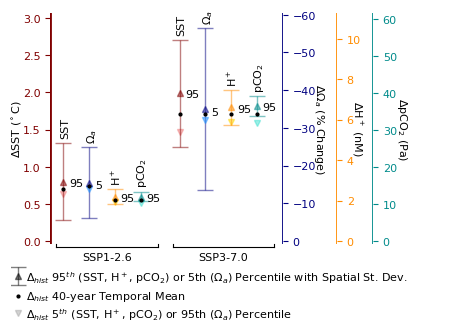

In [14]:
#### OMEGA_A AS % CHANGE FROM HISTORICAL BECAUSE IT IS A RATIO ####
s=2.4
ms1=4
fs1=8
cs=6
fig,ax1=plt.subplots(1,1,figsize=(3,3))
p1=ax1.get_position().bounds

isc='ESM4_ssp126_D1'
ivar='tos'
ax1.plot(0,meanDelt[(isc,ivar,qql)],marker='v',color='lightcoral',alpha=.5,ms=ms1)
ax1.errorbar(0,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='maroon',alpha=.5,ms=ms1)
ax1.annotate(str(int(qqh*100)),xy=[0,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)#+'$^{th}$'
ax1.annotate('SST',xy=[0,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90,annotation_clip=False)
ax1.plot(0,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='omega_arag_0'
ax2=ax1.twinx()
ax2.errorbar(0.1,meanDelt[(isc,ivar,qql)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='navy',alpha=.5,ms=ms1)
ax2.plot(0.1,meanDelt[(isc,ivar,qqh)],marker='v',color='dodgerblue',alpha=.5,ms=ms1)
ax2.annotate(str(int(qql*100)),xy=[0.1,meanDelt[(isc,ivar,qql)]],xytext=[4,-2],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax2.annotate('$\Omega _{a}$',xy=[0.1,meanDelt[(isc,ivar,qql)]-stdvDelt[(isc,ivar,qql)]],xytext=[2,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax2.plot(0.1,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='hplusos'
ax3=ax1.twinx()
ax3.plot(0.2,1e3*meanDelt[(isc,ivar,qql)],marker='v',color='gold',alpha=.5,ms=ms1)
ax3.errorbar(0.2,1e3*meanDelt[(isc,ivar,qqh)],yerr=1e3*stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkorange',alpha=.5,ms=ms1)
ax3.annotate(str(int(qqh*100)),xy=[0.2,1e3*meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax3.annotate('H$^+$',xy=[0.2,1e3*meanDelt[(isc,ivar,qqh)]+1e3*stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax3.plot(0.2,1e3*meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

ivar='spco2'
ax4=ax1.twinx()
ax4.plot(0.3,meanDelt[(isc,ivar,qql)],marker='v',color='turquoise',alpha=.5,ms=ms1)
ax4.errorbar(0.3,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='darkcyan',alpha=.5,ms=ms1)
ax4.annotate(str(int(qqh*100)),xy=[0.3,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax4.annotate('pCO$_2$',xy=[0.3,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax4.plot(0.3,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

isc='ESM4_ssp370_D1'
ivar='tos'
ax1.plot(.45,meanDelt[(isc,ivar,qql)],marker='v',color='lightcoral',alpha=.5,ms=ms1)
ax1.errorbar(.45,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='maroon',alpha=.5,ms=ms1)
ax1.annotate(str(int(qqh*100)),xy=[.45,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax1.annotate('SST',xy=[0.45,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90,annotation_clip=False)
ax1.plot(.45,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax1.set_ylim(-.01*s*a,.75*s*a)

ivar='omega_arag_0'
ax2.errorbar(0.55,meanDelt[(isc,ivar,qql)],yerr=stdvDelt[(isc,ivar,qql)],
           capsize=cs,linestyle='None',marker='^',color='navy',alpha=.5,ms=ms1)
ax2.plot(0.55,meanDelt[(isc,ivar,qqh)],marker='v',color='dodgerblue',alpha=.5,ms=ms1)
ax2.annotate(str(int(qql*100)),xy=[0.55,meanDelt[(isc,ivar,qql)]],xytext=[4,-2],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax2.annotate('$\Omega _{a}$',xy=[0.55,meanDelt[(isc,ivar,qql)]-stdvDelt[(isc,ivar,qql)]],xytext=[2,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax2.plot(0.55,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax2.set_ylim(-.01*s*a,.75*s*a)

ivar='hplusos'
ax3.plot(0.65,1e3*meanDelt[(isc,ivar,qql)],marker='v',color='gold',alpha=.5,ms=ms1)
ax3.errorbar(0.65,1e3*meanDelt[(isc,ivar,qqh)],yerr=1e3*stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkorange',alpha=.5,ms=ms1)
ax3.annotate(str(int(qqh*100)),xy=[0.65,1e3*meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax3.annotate('H$^+$',xy=[0.65,1e3*meanDelt[(isc,ivar,qqh)]+1e3*stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax3.plot(0.65,1e3*meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=1e3*meanDelt[(isc,ivar,'mean')]
ax3.set_ylim(-.01*s*a,.75*s*a)

ivar='spco2'
ax4.plot(0.75,meanDelt[(isc,ivar,qql)],marker='v',color='turquoise',alpha=.5,ms=ms1)
ax4.errorbar(0.75,meanDelt[(isc,ivar,qqh)],yerr=stdvDelt[(isc,ivar,qqh)],
           capsize=cs,linestyle='None',marker='^',color='darkcyan',alpha=.5,ms=ms1)
ax4.annotate(str(int(qqh*100)),xy=[0.75,meanDelt[(isc,ivar,qqh)]],xytext=[4,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
ax4.annotate('pCO$_2$',xy=[0.75,meanDelt[(isc,ivar,qqh)]+stdvDelt[(isc,ivar,qqh)]],xytext=[1,3],
                                   textcoords='offset points',ha='center',va='bottom',fontsize=fs1,rotation=90)
ax4.plot(0.75,meanDelt[(isc,ivar,'mean')],'k.',zorder=3,ms=ms1)
a=meanDelt[(isc,ivar,'mean')]
ax4.set_ylim(-.01*s*a,.75*s*a)

ax1.set_xlim(-.05,.85)
for iax in [ax1,ax2,ax3,ax4]:
    iax.set_frame_on(False)
    iax.yaxis.set_visible(False)
    
    
def showax(axx,shift,color,side):
    p0=axx.get_position().bounds
    if side=='left':
        p1=[p0[0]+shift,p0[1],.02,p0[3]]
        axb=fig.add_axes(p1,sharey=axx,frameon=False)
        axb.spines['left'].set_color(color)
        axb.get_yaxis().set_visible(True)
        xmin, xmax = axb.get_xaxis().get_view_interval()
        ymin, ymax = axb.get_yaxis().get_view_interval()
        axb.add_artist(Line2D((xmin, xmin), (ymin, ymax), color=color, linewidth=2))
    else:
        p1=[p0[0]+p0[2]-.02+shift,p0[1],.02,p0[3]]
        axb=fig.add_axes(p1,sharey=axx,frameon=False)
        axb.spines['right'].set_color(color)
        axb.spines['left'].set_visible(False)
        xmin, xmax = axb.get_xaxis().get_view_interval()
        ymin, ymax = axb.get_yaxis().get_view_interval()
        axb.add_artist(Line2D((xmax, xmax), (ymin, ymax), color=color, linewidth=2))
        axb.yaxis.tick_right()
        axb.yaxis.set_label_position("right")
    axb.tick_params(axis='y', colors=color)
    #axb.spines['top'].set_visible(False)
    #axb.spines['bottom'].set_visible(False)
    axb.set_xticks([])
    return axb
        
ax1b=showax(ax1,0,'maroon','left')
ax2b=showax(ax2,0,'navy','right')
ax3b=showax(ax3,.18,'darkorange','right')
ax4b=showax(ax4,.3,'darkcyan','right')
ax1b.set_ylabel('$\Delta$SST ($^\circ$C)',labelpad=0)
ax2b.set_ylabel('$\Delta \Omega _{a}$ (% Change)',rotation=-90,labelpad=7)
ax3b.set_ylabel('$\Delta$H$^+$ (nM)',rotation=-90,labelpad=2)
ax4b.set_ylabel('$\Delta$pCO$_2$ (Pa)',rotation=-90,labelpad=9)
ax1.set_xticks([]);
#ax2b.set_yticks([0,-.5,-1,-1.5])

axl1=fig.add_axes([p1[0]+.02,p1[1]-.01,p1[2]/2-.05,.01])
axl2=fig.add_axes([p1[0]+.02+p1[2]/2,p1[1]-.01,p1[2]/2-.05,.01])
for iax in [axl1,axl2]:
    iax.set_xticks([])
    iax.set_yticks([])
    iax.spines[['top']].set_visible(False)
axl1.set_xlabel('SSP1-2.6')
axl2.set_xlabel('SSP3-7.0')

axl=fig.add_axes([0*p1[0]-.008,p1[1]-.27,p1[2]*1.87,.2])
axl.errorbar(1,.82,yerr=.15,
           capsize=cs,linestyle='None',marker='^',color='k',alpha=.5,ms=ms1)
axl.plot(1,.48,'.',color='k',ms=ms1)
axl.plot(1,.2,'v',color='darkgray',alpha=.5,ms=ms1)
axl.annotate('$\Delta_{hist}$ 95$^{th}$ (SST, H$^+$, pCO$_2$) or 5th ($\Omega _{a}$) Percentile with Spatial St. Dev.',
             xy=[1.03,.82],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
# axl.annotate('with Spatial Standard Deviation (errorbars)',
#              xy=[1.2,.63],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.annotate('$\Delta_{hist}$ 40-year Temporal Mean',
             xy=[1.03,.48],xytext=[5,0],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.annotate('$\Delta_{hist}$ 5$^{th}$ (SST, H$^+$, pCO$_2$) or 95th ($\Omega _{a}$) Percentile',
             xy=[1.03,.2],xytext=[5,-1],textcoords='offset points',ha='left',va='center',fontsize=fs1)
axl.set_axis_off()
axl.set_xlim(0.85,10)
axl.set_ylim(0,1)

# fig.savefig(f'/home/Elise.Olson/OAPMSE/extremesFigs/deltas.png',
#             dpi=300,bbox_inches='tight')

In [12]:
stats['ESM4_historical_D1']['spco2']

<xarray.Dataset> Size: 12GB
Dimensions:      (time: 1, lat: 180, lon: 360, quantile: 13, b: 2, YD: 365,
                  YD5: 73)
Coordinates:
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon          (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time         (time) object 8B 1995-01-01 00:00:00
  * YD           (YD) int64 3kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * quantile     (quantile) float64 104B 0.0 0.02 0.05 0.07 ... 0.95 0.98 1.0
  * b            (b) int64 16B 0 1
  * YD5          (YD5) int64 584B 1 6 11 16 21 26 31 ... 336 341 346 351 356 361
Data variables: (12/22)
    mean         (time, lat, lon) float32 259kB ...
    var          (time, lat, lon) float32 259kB ...
    qt           (quantile, lat, lon) float64 7MB ...
    linfitcoef   (b, lat, lon) float64 1MB ...
    binseas      (YD, lat, lon) float64 189MB ...
    seas         (YD, lat, lon) float64 189MB ...
    ...           ...
    ydqt_ds2     (YD5, quantile, lat, lon) float64 492MB ...
    ydqt_dtds2   (YD5, quantile, lat, lon) float64 492MB ...
    ydqt2S       (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dt2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_ds2S    (YD, quantile, lat, lon) float64 2GB ...
    ydqt_dtds2S  (YD, quantile, lat, lon) float64 2GB ...
Attributes:
    long_name:                   Surface Aqueous Partial Pressure of CO2
    units:                       Pa
    standard_name:               surface_partial_pressure_of_carbon_dioxide_i...
    varname:                     spco2
    year-day quantile Descript:  full series fits are applied to dt and ds va...
    ydqt halfwindow:             2

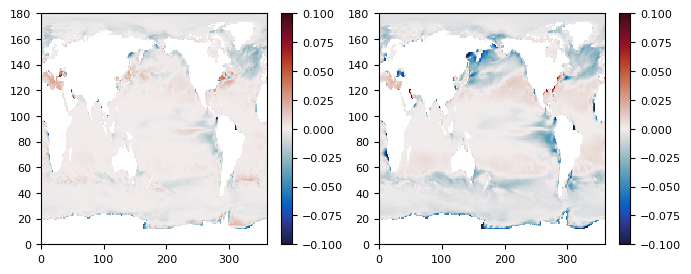

In [13]:
cm1=cmocean.cm.balance
fig,ax=plt.subplots(1,2,figsize=(8,3))
m0=ax[0].pcolormesh(stats['ESM4_ssp126_D1']['omega_arag_0']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['omega_arag_0']['var_seas'][0,:,:],cmap=cm1,norm=mcol.CenteredNorm(0,.1))
fig.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(stats['ESM4_ssp370_D1']['omega_arag_0']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['omega_arag_0']['var_seas'][0,:,:],cmap=cm1,norm=mcol.CenteredNorm(0,.1))
fig.colorbar(m1,ax=ax[1])

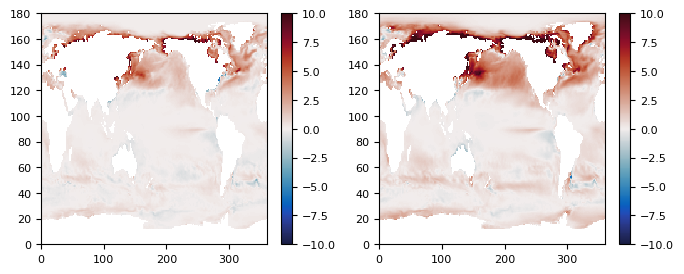

In [14]:
cm1=cmocean.cm.balance
fig,ax=plt.subplots(1,2,figsize=(8,3))
m0=ax[0].pcolormesh(stats['ESM4_ssp126_D1']['tos']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['tos']['var_seas'][0,:,:],cmap=cm1,norm=mcol.CenteredNorm(0,10))
fig.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(stats['ESM4_ssp370_D1']['tos']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['tos']['var_seas'][0,:,:],cmap=cm1,norm=mcol.CenteredNorm(0,10))
fig.colorbar(m1,ax=ax[1])

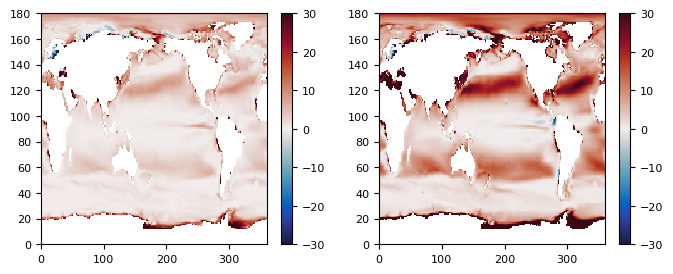

In [15]:
cm1=cmocean.cm.balance
fig,ax=plt.subplots(1,2,figsize=(8,3))
m0=ax[0].pcolormesh(stats['ESM4_ssp126_D1']['spco2']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['spco2']['var_seas'][0,:,:],cmap=cm1,
                    norm=mcol.CenteredNorm(0,30))
fig.colorbar(m0,ax=ax[0])
m1=ax[1].pcolormesh(stats['ESM4_ssp370_D1']['spco2']['var_seas'][0,:,:]-stats['ESM4_historical_D1']['spco2']['var_seas'][0,:,:],cmap=cm1,
                    norm=mcol.CenteredNorm(0,30))
fig.colorbar(m1,ax=ax[1])